#Mounting the dataset from drive to colab


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## loading the datsets

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Load the datasets
prev_data_path = '/content/drive/MyDrive/research data/dataset1ofresearch modified.csv'
new_data_path = '/content/drive/MyDrive/research data/dataset2ofresearch modified.xlsx'

prev_data = pd.read_csv(prev_data_path, header=None, delimiter=',')
new_data = pd.read_excel(new_data_path, header=None)

# Preprocess the data from previous dataset
prev_data = prev_data.rename(columns={1: 2})
prev_data.insert(1, 1, "")

race = []
for ctry in list(prev_data[0]):
    if ctry in ['Kenyan', 'Nigerian']:
        race.append('African')
    elif ctry in ['Chinese', 'Indian']:
        race.append('Asian')
    elif ctry in ['British', 'Canadian']:
        race.append('Caucasian')
    else:
        race.append('Unknown')
prev_data[1] = pd.DataFrame(race)

# Preprocess the new dataset
nationality = []
dna_sequence = []
race = []
for dna in range(len(new_data[0])):
    if 'Ethiopian' in str(new_data[0][dna]) or 'Niger' in str(new_data[0][dna]):
        nationality.append(new_data[0][dna])
        dna_sequence.append(new_data[0][dna + 1: dna + 6])
        race.append('African')
    elif 'Japanese' in str(new_data[0][dna]):
        nationality.append(new_data[0][dna])
        dna_sequence.append(new_data[0][dna + 1: dna + 6])
        race.append('Asian')
    elif 'Korean' in str(new_data[0][dna]):
        nationality.append(new_data[0][dna])
        dna_sequence.append(new_data[0][dna + 1: dna + 5])
        race.append('Asian')
    elif 'German' in str(new_data[0][dna]):
        nationality.append(new_data[0][dna])
        dna_sequence.append(new_data[0][dna + 1: dna + 4])
        race.append('Caucasian')
    elif 'Russian' in str(new_data[0][dna]):
        nationality.append(new_data[0][dna])
        dna_sequence.append(new_data[0][dna + 1: dna + 5])
        race.append('Caucasian')

dna_sequences = []
for sequence in dna_sequence:
    lst = ''.join(sequence)
    dna_sequences.append(lst)

cleaned_data = pd.DataFrame({
    0: nationality,
    1: race,
    2: dna_sequences
})

temp_data = cleaned_data[0].str.split(" ", expand=True)
cleaned_data[0] = temp_data[0]

# Combine previous and new datasets
data = pd.concat([prev_data, cleaned_data], ignore_index=True)

# Define functions for preprocessing
def string_to_array(my_string):
    my_string = my_string.lower()
    my_string = re.sub('[^acgt]', 'z', my_string)
    my_array = np.array(list(my_string))
    return my_array

label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a', 'c', 'g', 't', 'z']))

def one_hot_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded

def getKmers(sequence, size):
    return [sequence[x:x + size].lower() for x in range(len(sequence) - size + 1)]

# Create Bag of Words model
bag_of_sentences = []
for i in data[2]:
    words = getKmers(i, size=6)
    sentence = ' '.join(words)
    bag_of_sentences.append(sentence)

cv = CountVectorizer()
X = cv.fit_transform(bag_of_sentences).toarray()

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=50)  # Adjust n_components based on the explained variance
X_pca = pca.fit_transform(X_normalized)

# Split data into old and new
oldX = X_pca[:270]
newX = X_pca[270:]

old_y = data[1][:270]
new_y = data[1][270:]

# Encode labels
old_y_n = old_y.astype('category').cat.codes
new_y_n = new_y.astype('category').cat.codes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(oldX, old_y_n, test_size=0.20, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((216, 50), (54, 50), (216,), (54,))

##SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score

# Define the SVM model
svm_model = SVC(C=1.0, gamma='scale', kernel='rbf')

# Train the model
svm_model.fit(X_train, y_train) # Use X_train instead of X_train_pca

# Evaluate the model on the test set
y_pred_svm = svm_model.predict(X_test) # Use X_test instead of X_test_pca
svm_test_accuracy = accuracy_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

# Perform cross-validation
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5) # Use X_train instead of X_train_pca

# Display the results
print("SVM Model")
print(f"Test accuracy: {svm_test_accuracy:.2f}")
print(f"Cross-validation accuracy (mean): {svm_cv_scores.mean():.2f}")
print(f"Cross-validation accuracy (std): {svm_cv_scores.std():.2f}")
print(f"Recall: {svm_recall:.2f}")
print(f"Precision: {svm_precision:.2f}")
print(f"F1 Score: {svm_f1:.2f}")



SVM Model
Test accuracy: 0.89
Cross-validation accuracy (mean): 0.84
Cross-validation accuracy (std): 0.03
Recall: 0.89
Precision: 0.89
F1 Score: 0.89


##RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score

# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_rf = rf_model.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

# Perform cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Display the results
print("Random Forest Model")
print(f"Test accuracy: {rf_test_accuracy:.2f}")
print(f"Cross-validation accuracy (mean): {rf_cv_scores.mean():.2f}")
print(f"Cross-validation accuracy (std): {rf_cv_scores.std():.2f}")
print(f"Recall: {rf_recall:.2f}")
print(f"Precision: {rf_precision:.2f}")
print(f"F1 Score: {rf_f1:.2f}")





Random Forest Model
Test accuracy: 0.93
Cross-validation accuracy (mean): 0.80
Cross-validation accuracy (std): 0.06
Recall: 0.93
Precision: 0.93
F1 Score: 0.92


##LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score

# Define the LDA model
lda_model = LinearDiscriminantAnalysis()

# Train the model
lda_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_lda = lda_model.predict(X_test)
lda_test_accuracy = accuracy_score(y_test, y_pred_lda)
lda_recall = recall_score(y_test, y_pred_lda, average='weighted')
lda_precision = precision_score(y_test, y_pred_lda, average='weighted')
lda_f1 = f1_score(y_test, y_pred_lda, average='weighted')

# Perform cross-validation
lda_cv_scores = cross_val_score(lda_model, X_train, y_train, cv=5)

# Display the results
print("LDA Model")
print(f"Test accuracy: {lda_test_accuracy:.2f}")
print(f"Cross-validation accuracy (mean): {lda_cv_scores.mean():.2f}")
print(f"Cross-validation accuracy (std): {lda_cv_scores.std():.2f}")
print(f"Recall: {lda_recall:.2f}")
print(f"Precision: {lda_precision:.2f}")
print(f"F1 Score: {lda_f1:.2f}")





LDA Model
Test accuracy: 0.85
Cross-validation accuracy (mean): 0.80
Cross-validation accuracy (std): 0.06
Recall: 0.85
Precision: 0.85
F1 Score: 0.85


##QDA

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score

# Define the QDA model
qda_model = QuadraticDiscriminantAnalysis()

# Train the model
qda_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_qda = qda_model.predict(X_test)
qda_test_accuracy = accuracy_score(y_test, y_pred_qda)
qda_recall = recall_score(y_test, y_pred_qda, average='weighted')
qda_precision = precision_score(y_test, y_pred_qda, average='weighted')
qda_f1 = f1_score(y_test, y_pred_qda, average='weighted')

# Perform cross-validation
qda_cv_scores = cross_val_score(qda_model, X_train, y_train, cv=5)

# Display the results
print("QDA Model")
print(f"Test accuracy: {qda_test_accuracy:.2f}")
print(f"Cross-validation accuracy (mean): {qda_cv_scores.mean():.2f}")
print(f"Cross-validation accuracy (std): {qda_cv_scores.std():.2f}")
print(f"Recall: {qda_recall:.2f}")
print(f"Precision: {qda_precision:.2f}")
print(f"F1 Score: {qda_f1:.2f}")




QDA Model
Test accuracy: 0.72
Cross-validation accuracy (mean): 0.65
Cross-validation accuracy (std): 0.04
Recall: 0.72
Precision: 0.83
F1 Score: 0.68


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score

# Define the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_knn = knn_model.predict(X_test)
knn_test_accuracy = accuracy_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn, average='weighted')
knn_precision = precision_score(y_test, y_pred_knn, average='weighted')
knn_f1 = f1_score(y_test, y_pred_knn, average='weighted')

# Perform cross-validation
knn_cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5)

# Display the results
print("k-NN Model")
print(f"Test accuracy: {knn_test_accuracy:.2f}")
print(f"Cross-validation accuracy (mean): {knn_cv_scores.mean():.2f}")
print(f"Cross-validation accuracy (std): {knn_cv_scores.std():.2f}")
print(f"Recall: {knn_recall:.2f}")
print(f"Precision: {knn_precision:.2f}")
print(f"F1 Score: {knn_f1:.2f}")




k-NN Model
Test accuracy: 0.91
Cross-validation accuracy (mean): 0.80
Cross-validation accuracy (std): 0.02
Recall: 0.91
Precision: 0.92
F1 Score: 0.91


##Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score

# Define the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_gb = gb_model.predict(X_test)
gb_test_accuracy = accuracy_score(y_test, y_pred_gb)
gb_recall = recall_score(y_test, y_pred_gb, average='weighted')
gb_precision = precision_score(y_test, y_pred_gb, average='weighted')
gb_f1 = f1_score(y_test, y_pred_gb, average='weighted')

# Perform cross-validation
gb_cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5)

# Display the results
print("Gradient Boosting Model")
print(f"Test accuracy: {gb_test_accuracy:.2f}")
print(f"Cross-validation accuracy (mean): {gb_cv_scores.mean():.2f}")
print(f"Cross-validation accuracy (std): {gb_cv_scores.std():.2f}")
print(f"Recall: {gb_recall:.2f}")
print(f"Precision: {gb_precision:.2f}")
print(f"F1 Score: {gb_f1:.2f}")




Gradient Boosting Model
Test accuracy: 0.94
Cross-validation accuracy (mean): 0.79
Cross-validation accuracy (std): 0.04
Recall: 0.94
Precision: 0.95
F1 Score: 0.94


##XGBoost with GridSearchCV

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Display the results
print("Best parameters found: ", best_params)
print("Best cross-validation accuracy: ", best_score)

# Evaluate the best model on the test set
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
xgb_test_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb, average='weighted')
xgb_precision = precision_score(y_test, y_pred_xgb, average='weighted')
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')

# Display the results
print("Best XGBoost Model")
print(f"Test accuracy: {xgb_test_accuracy:.2f}")
print(f"Recall: {xgb_recall:.2f}")
print(f"Precision: {xgb_precision:.2f}")
print(f"F1 Score: {xgb_f1:.2f}")



Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation accuracy:  0.8332980972515858
Best XGBoost Model
Test accuracy: 0.94
Recall: 0.94
Precision: 0.94
F1 Score: 0.94


##LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score

# Define the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Train the model
lgb_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_lgb = lgb_model.predict(X_test)
lgb_test_accuracy = accuracy_score(y_test, y_pred_lgb)
lgb_recall = recall_score(y_test, y_pred_lgb, average='weighted')
lgb_precision = precision_score(y_test, y_pred_lgb, average='weighted')
lgb_f1 = f1_score(y_test, y_pred_lgb, average='weighted')

# Perform cross-validation
lgb_cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=5)

# Display the results
print("LightGBM Model")
print(f"Test accuracy: {lgb_test_accuracy:.2f}")
print(f"Cross-validation accuracy (mean): {lgb_cv_scores.mean():.2f}")
print(f"Cross-validation accuracy (std): {lgb_cv_scores.std():.2f}")
print(f"Recall: {lgb_recall:.2f}")
print(f"Precision: {lgb_precision:.2f}")
print(f"F1 Score: {lgb_f1:.2f}")



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 50
[LightGBM] [Info] Start training from score -1.126783
[LightGBM] [Info] Start training from score -1.057790
[LightGBM] [Info] Start training from score -1.848918
[LightGBM] [Info] Start training from score -1.764360
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

##CatBoost

In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(random_seed=42, verbose=0)

# Train the model
catboost_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_catboost = catboost_model.predict(X_test)
catboost_test_accuracy = accuracy_score(y_test, y_pred_catboost)
catboost_recall = recall_score(y_test, y_pred_catboost, average='weighted')
catboost_precision = precision_score(y_test, y_pred_catboost, average='weighted')
catboost_f1 = f1_score(y_test, y_pred_catboost, average='weighted')

# Display the results
print("CatBoost Model")
print(f"Test accuracy: {catboost_test_accuracy:.2f}")
print(f"Recall: {catboost_recall:.2f}")
print(f"Precision: {catboost_precision:.2f}")
print(f"F1 Score: {catboost_f1:.2f}")

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(CatBoostClassifier(random_seed=42, verbose=0), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Display the best parameters and cross-validation score
print("Best parameters found: ", best_params)
print("Best cross-validation accuracy: ", best_score)

# Evaluate the best model on the test set
best_catboost_model = grid_search.best_estimator_
y_pred_best_catboost = best_catboost_model.predict(X_test)
best_catboost_test_accuracy = accuracy_score(y_test, y_pred_best_catboost)
best_catboost_recall = recall_score(y_test, y_pred_best_catboost, average='weighted')
best_catboost_precision = precision_score(y_test, y_pred_best_catboost, average='weighted')
best_catboost_f1 = f1_score(y_test, y_pred_best_catboost, average='weighted')

# Display the test accuracy and other metrics
print("Best CatBoost Model")
print(f"Test accuracy: {best_catboost_test_accuracy:.2f}")
print(f"Recall: {best_catboost_recall:.2f}")
print(f"Precision: {best_catboost_precision:.2f}")
print(f"F1 Score: {best_catboost_f1:.2f}")



CatBoost Model
Test accuracy: 0.94
Recall: 0.94
Precision: 0.95
F1 Score: 0.94
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'depth': 4, 'iterations': 300, 'learning_rate': 0.2}
Best cross-validation accuracy:  0.828752642706131
Best CatBoost Model
Test accuracy: 0.94
Recall: 0.94
Precision: 0.95
F1 Score: 0.94


##Stacking Classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score

# Assuming X_train_pca and X_test_pca are already defined
# X_train_pca = <your preprocessed training data>
# X_test_pca = <your preprocessed testing data>
# y_train, y_test = <your labels>

# Define base models
base_learners = [
    ('svm', SVC(C=1.0, gamma='scale', kernel='rbf', probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]

# Define meta-learner
meta_learner = LogisticRegression()

# Initialize the Stacking Classifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Train the model
stacking_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_stacking = stacking_model.predict(X_test)
stacking_test_accuracy = accuracy_score(y_test, y_pred_stacking)
stacking_recall = recall_score(y_test, y_pred_stacking, average='weighted')
stacking_precision = precision_score(y_test, y_pred_stacking, average='weighted')
stacking_f1 = f1_score(y_test, y_pred_stacking, average='weighted')

# Perform cross-validation
stacking_cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5)

# Display the results
print("Stacking Classifier")
print(f"Test accuracy: {stacking_test_accuracy:.2f}")
print(f"Cross-validation accuracy (mean): {stacking_cv_scores.mean():.2f}")
print(f"Cross-validation accuracy (std): {stacking_cv_scores.std():.2f}")
print(f"Recall: {stacking_recall:.2f}")
print(f"Precision: {stacking_precision:.2f}")
print(f"F1 Score: {stacking_f1:.2f}")


Stacking Classifier
Test accuracy: 0.91
Cross-validation accuracy (mean): 0.82
Cross-validation accuracy (std): 0.02
Recall: 0.91
Precision: 0.91
F1 Score: 0.91


###performance

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 50
[LightGBM] [Info] Start training from score -1.126783
[LightGBM] [Info] Start training from score -1.057790
[LightGBM] [Info] Start training from score -1.848918
[LightGBM] [Info] Start training from score -1.764360
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:11:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


               Model  Accuracy    Recall  Precision  F1 Score
0                SVM  0.888889  0.888889   0.889660  0.888578
1      Random Forest  0.925926  0.925926   0.933025  0.924967
2                LDA  0.870370  0.870370   0.872166  0.868750
3                QDA  0.722222  0.722222   0.828196  0.683678
4               k-NN  0.907407  0.907407   0.916226  0.905442
5  Gradient Boosting  0.962963  0.962963   0.966862  0.961677
6           LightGBM  0.888889  0.888889   0.889842  0.888658
7           CatBoost  0.962963  0.962963   0.963992  0.962683
8            XGBoost  0.962963  0.962963   0.963992  0.962929
9           Stacking  0.907407  0.907407   0.909518  0.907969


<ipython-input-10-c489e4d08c49>:78: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


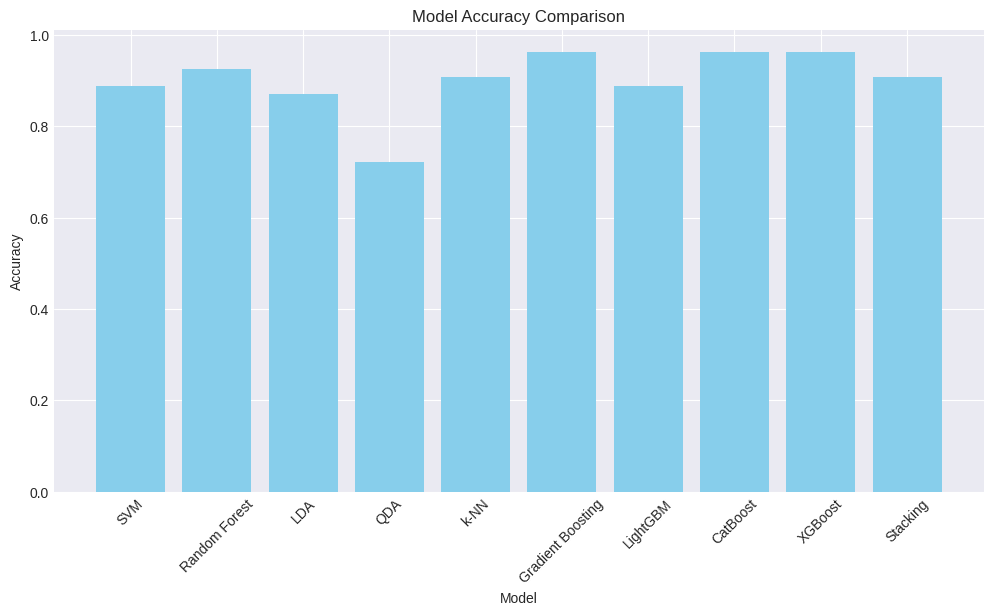

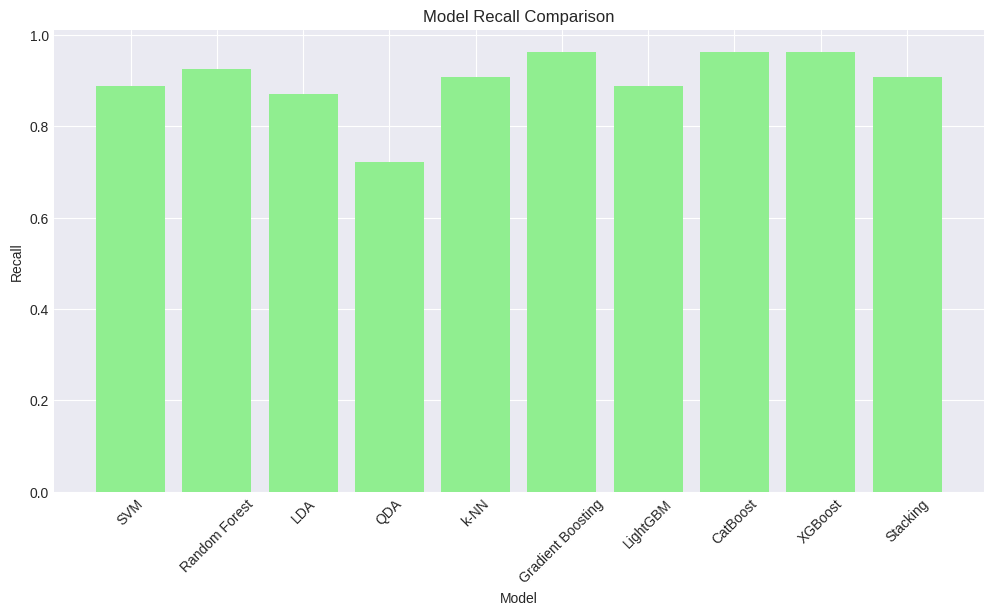

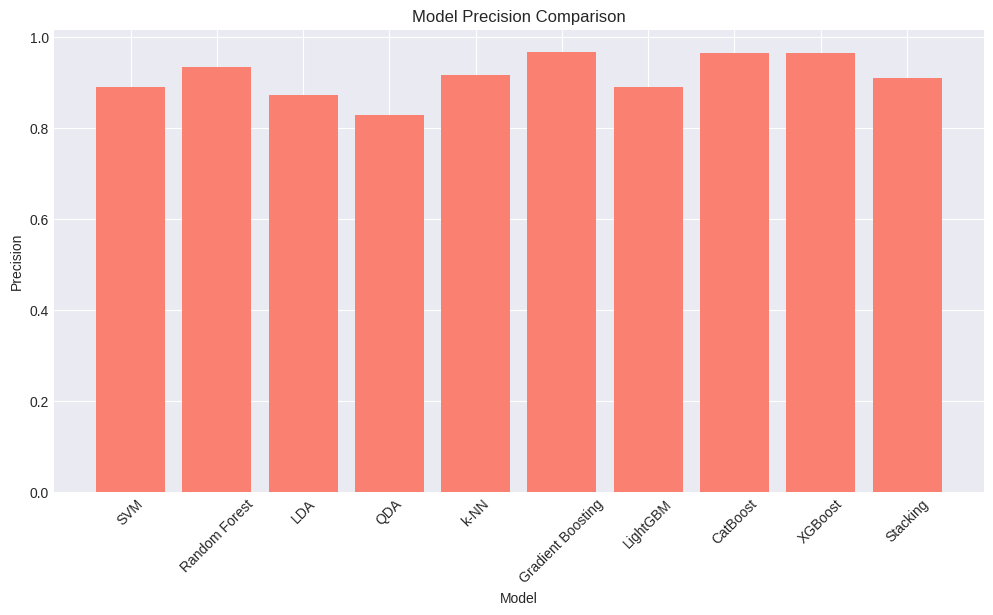

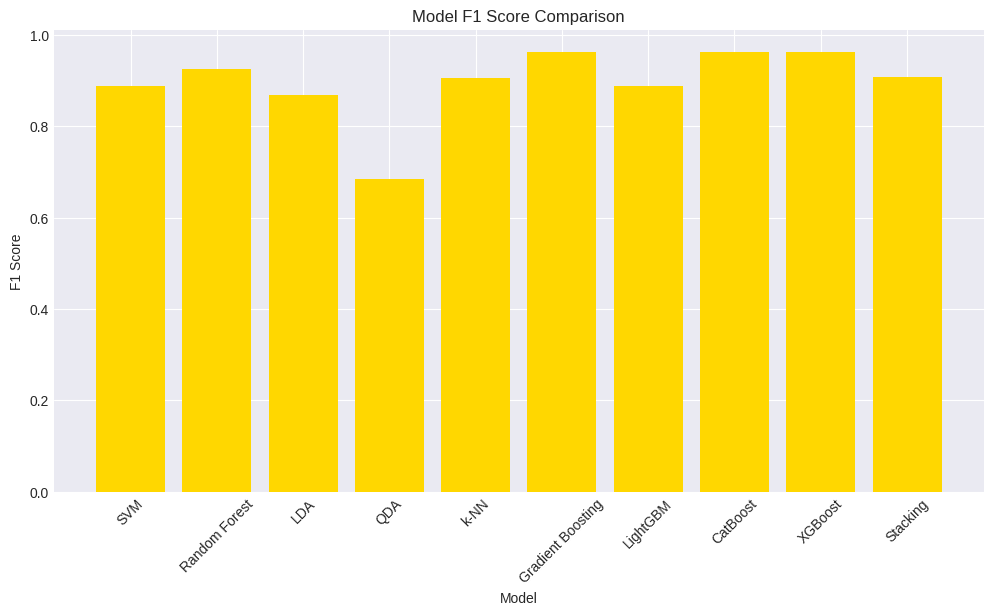

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Assuming X_train_pca and X_test_pca are already defined
# X_train_pca = <your preprocessed training data>
# X_test_pca = <your preprocessed testing data>
# y_train, y_test = <your labels>

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, recall, precision, f1

# Initialize models
models = {
    'SVM': SVC(C=1.0, gamma='scale', kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_seed=42, verbose=0),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Define base models for Stacking Classifier
base_learners = [
    ('svm', SVC(C=1.0, gamma='scale', kernel='rbf', probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]
meta_learner = LogisticRegression()
models['Stacking'] = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Evaluate models and collect metrics
metrics = {'Model': [], 'Accuracy': [], 'Recall': [], 'Precision': [], 'F1 Score': []}
for name, model in models.items():
    accuracy, recall, precision, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy)
    metrics['Recall'].append(recall)
    metrics['Precision'].append(precision)
    metrics['F1 Score'].append(f1)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print(metrics_df)

# Set the style
plt.style.use('seaborn-darkgrid')

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['Accuracy'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

# Plot Recall
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['Recall'], color='lightgreen')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Model Recall Comparison')
plt.xticks(rotation=45)
plt.show()

# Plot Precision
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['Precision'], color='salmon')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Model Precision Comparison')
plt.xticks(rotation=45)
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.bar(metrics_df['Model'], metrics_df['F1 Score'], color='gold')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Model F1 Score Comparison')
plt.xticks(rotation=45)
plt.show()


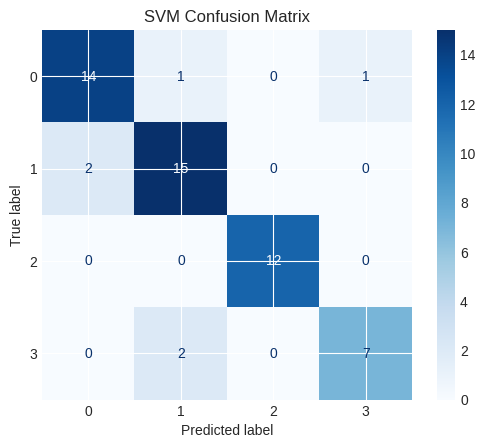

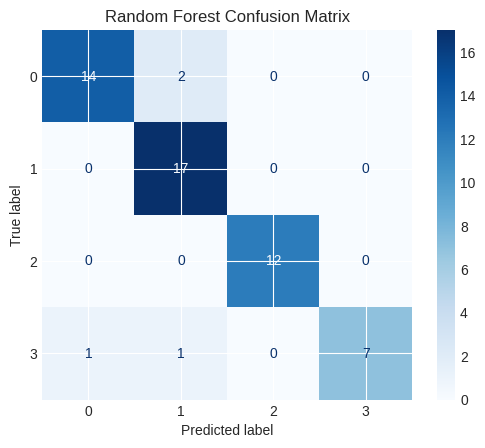

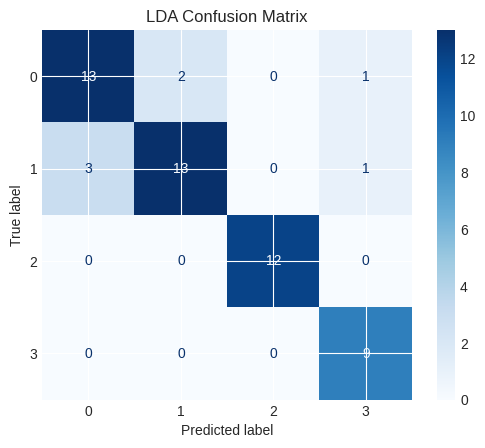

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


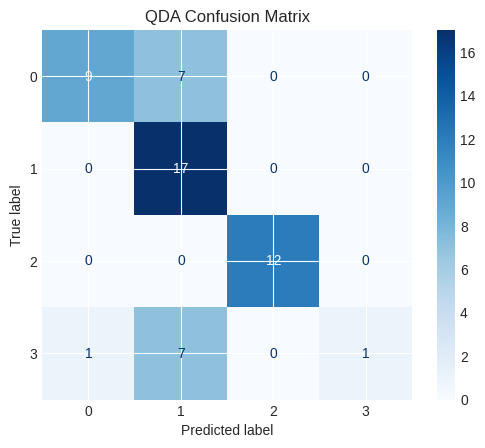

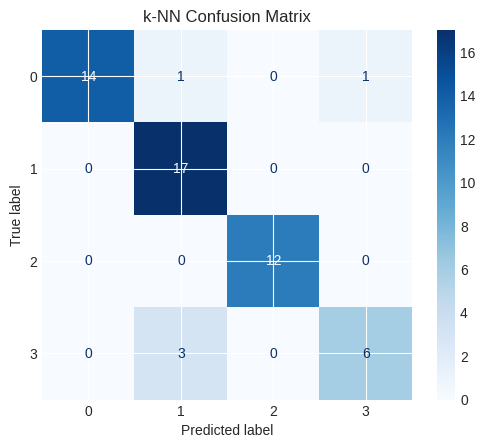

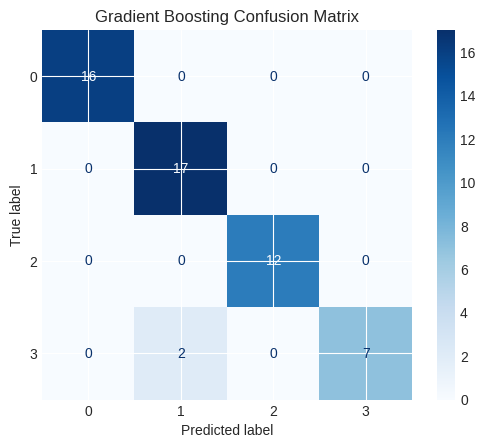

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 50
[LightGBM] [Info] Start training from score -1.126783
[LightGBM] [Info] Start training from score -1.057790
[LightGBM] [Info] Start training from score -1.848918
[LightGBM] [Info] Start training from score -1.764360
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

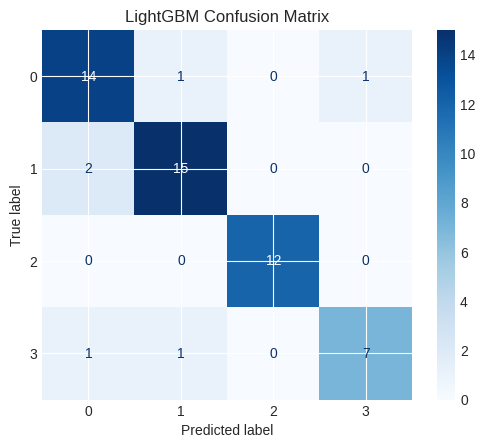

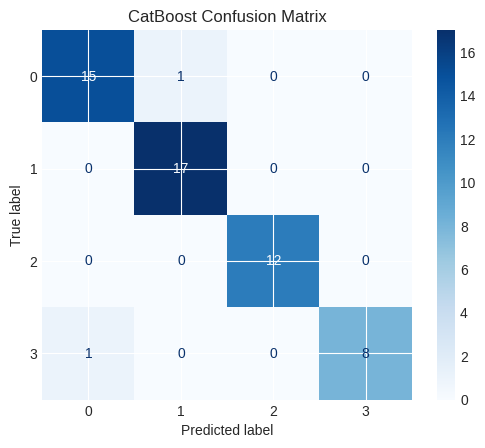

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:13:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


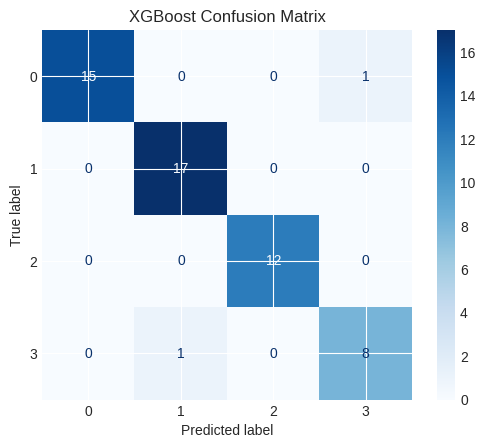

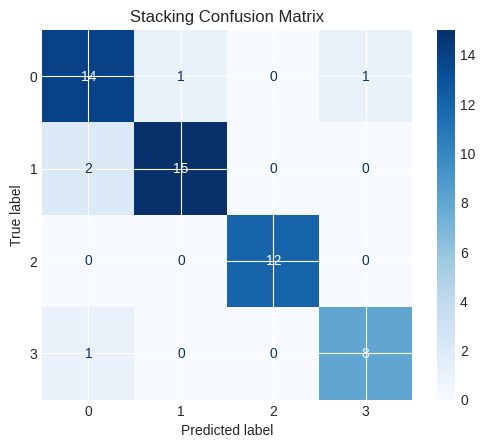

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test is already defined and X_test_pca is your test data
# y_test = <true labels>
# X_test_pca = <preprocessed test data>

# Define models
models = {
    'SVM': SVC(C=1.0, gamma='scale', kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_seed=42, verbose=0),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Define base models for Stacking Classifier
base_learners = [
    ('svm', SVC(C=1.0, gamma='scale', kernel='rbf', probability=True)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]
meta_learner = LogisticRegression()
models['Stacking'] = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Train models and generate confusion matrices
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Generate and display the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{name} Confusion Matrix')
    plt.show()


[LightGBM] [Info] Number of positive: 70, number of negative: 146
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.324074 -> initscore=-0.735111
[LightGBM] [Info] Start training from score -0.735111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:15:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


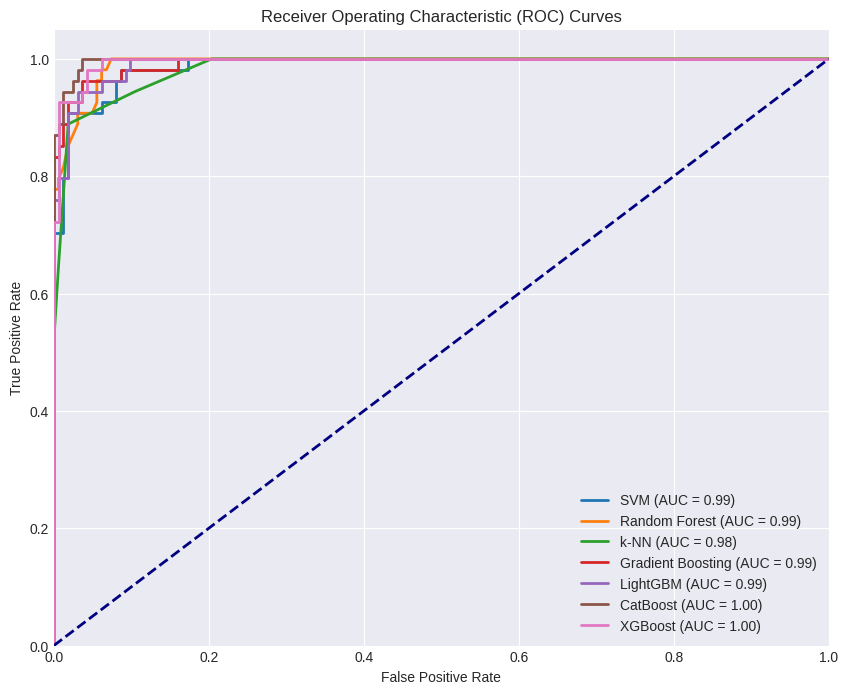

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Assuming X_train_pca, X_test_pca, y_train, y_test are already defined
# X_train_pca = <your preprocessed training data>
# X_test_pca = <your preprocessed testing data>
# y_train, y_test = <your labels>

# Binarize the output
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_bin.shape[1]

# Initialize models - Note: LDA and QDA do not have predict_proba
models = {
    'SVM': OneVsRestClassifier(SVC(C=1.0, gamma='scale', kernel='rbf', probability=True)),
    'Random Forest': OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    #'LDA': LinearDiscriminantAnalysis(),
    #'QDA': QuadraticDiscriminantAnalysis(),
    'k-NN': OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5)),
    'Gradient Boosting': OneVsRestClassifier(GradientBoostingClassifier(random_state=42)),
    'LightGBM': OneVsRestClassifier(lgb.LGBMClassifier(random_state=42)),
    'CatBoost': OneVsRestClassifier(CatBoostClassifier(random_seed=42, verbose=0)),
    'XGBoost': OneVsRestClassifier(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
}

# Plot ROC curves for each model
plt.figure(figsize=(10, 8))
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train_bin)

    # Predict probabilities
    y_prob = model.predict_proba(X_test)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for micro-average
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'{name} (AUC = {roc_auc["micro"]:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()